### prepare


In [74]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [75]:
import time
from typing import List
from pathlib import Path
import pickle

import hydra
from omegaconf import DictConfig

import gym
from gym.spaces import Box

import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
import torch
import seaborn as sns
from cycler import cycler


from d3rlpy.algos import SAC
from d3rlpy.algos import DoubleDQN as DDQN
from d3rlpy.algos import CQL
from d3rlpy.algos import IQL
from d3rlpy.algos import BCQ
from d3rlpy.algos import DiscreteCQL
from d3rlpy.algos import DiscreteBCQ
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy, ConstantEpsilonGreedy
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import BaseHead
from scope_rl.policy import GaussianHead
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.policy import SoftmaxHead
from scope_rl.policy import TrainCandidatePolicies

from scope_rl.ope.online import visualize_on_policy_policy_value
from scope_rl.ope.online import calc_on_policy_policy_value

from scope_rl.utils import MinMaxActionScaler
from scope_rl.utils import OldGymAPIWrapper
from scope_rl.types import LoggedDataset

from experiments.utils import torch_seed, format_runtime

from basicgym import BasicEnv

from tutorial.function import train_behavior_policy
from tutorial.function import obtain_logged_dataset
from tutorial.function import train_candidate_policies
# from experiments.main import off_policy_evaluation
from tutorial.function import off_policy_evaluation

### function

In [78]:
def visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    estimators,
    ESTIMATORS,
    x_scales,
    x_label,
    log_dir="../tutorial/logs/",
    yscale_log = False,
    xscale_log = False,
):

    # color_dict = {
    #     "dm": "#E24A33",
    #     "tis": "#348ABD",
    #     "pdis": "#0000FF",
    #     "dr": "#777777",
    #     "sntis": "#8EBA42",
    #     "snpdis": "#918D40",
    #     "sndr": "#FFB5B8",
    #     "sm_is": "#8c564b",
    #     "sm_dr": "#17becf",
    #     "sm_snis": "#bcbd22",
    #     "sm_sndr": "#233B6C",
    #     "sam_is": "#00BFFF",
    #     "sam_dr": "#FF00FF",
    #     "sam_snis": "#bcbd22",
    #     "sam_sndr": "#B22222",
    #     "drl": "#B1063A",
    # }
    color_dict = {
        "dm": "#E24A33",
        "tis": "#348ABD",
        "pdis": "#988ED5",
        "dr": "#777777",
        "sntis": "#8EBA42",
        "snpdis": "#FBC15E",
        "sndr": "#FFB5B8",
        "sm_is": "#FFA726",
        "sm_dr": "#17BECF",
        "sm_snis": "#F781BF",
        "sm_sndr": "#8C564B",
        # "sam_is": "#00FF00",
        "sam_is": "#FFA726",
        "sam_dr": "#008080",
        "sam_snis": "#000080",
        "sam_sndr": "#4B0082",
        # "drl": "#800000"
        "drl": "#F781BF"
    }
    # keys = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr", "sm_is",
    #         "sm_dr", "sm_snis", "sm_sndr", "sam_is", "sam_dr", "sam_snis",
    #         "sam_sndr", "drl"]

    # # カラーマップの取得
    # cmap = plt.get_cmap('coolwarm')

    # # カラーマップから色を生成して辞書に代入
    # color_dict = {key: plt.matplotlib.colors.to_hex(cmap(i / len(keys)))
    #             for i, key in enumerate(keys)}


    plt.style.use("ggplot")
    markers = ["o", "v", "^", "s", "p", "P", "*", "h", "X", "D", "d"]


    log_dir=log_dir

    metric_list = ['bias', 'variance', 'mse']

    for metric in metric_list:
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
        if metric =='bias':
            result_df = bias_result_df
        elif metric == 'variance':
            result_df = variance_result_df
        else:
            result_df = mse_result_df

        for i, estimator in enumerate(estimators):
            data = result_df[result_df['est']==estimator]
            data = data.query(f"({min(x_scales)}<= {x_label} <= {max(x_scales)})")
            ax.plot(
                np.array(x_scales),
                data[metric],
                color=color_dict[estimator],
                marker=markers[i],
                label=ESTIMATORS[i],
            )
            
            ax.legend(ESTIMATORS, loc="upper right", fontsize=20)

            ax.fill_between(
                np.array(x_scales),
                data['lower'],
                data['upper'],
                color=color_dict[estimator],
                alpha=0.3,
                label='',
            )

        # title and legend
        ax.legend(loc="upper right", fontsize=20)
        # yaxis
        if yscale_log:
            ax.set_yscale("log")
        ax.set_ylabel(metric, fontsize=25)
        ax.tick_params(axis="y", labelsize=15)
        ax.yaxis.set_label_coords(-0.08, 0.5)
        # xaxis
        if xscale_log:
            ax.set_xscale("log")
        ax.set_xlabel(f"number of trajectories", fontsize=25)
        # ax.set_xlabel(f"number of {x_label}", fontsize=25)
        ax.set_xticks(x_scales)
        ax.set_xticklabels(x_scales, fontsize=15)
        ax.xaxis.set_label_coords(0.5, -0.1)

        path_ = Path(log_dir + "/results/fig")
        path_.mkdir(exist_ok=True, parents=True)
        save_path = Path(path_ / f"{metric}_result_fig_{x_label}_{ESTIMATORS}.png")
        fig.tight_layout()
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

In [79]:
tmp_log_dir = "best n_random_state=100 step_per=15 n_action=5 behavior_tau = 3.5"
# tmp_log_dir = "tutorial_logs/logs"

### main

In [80]:
path_ = Path(tmp_log_dir + f"/results/df")

# variable_name='step_per_trajectory'
variable_name='n_trajectories'
# variable_name='n_actions'


path_bias = Path(path_ / f"bias_result_df_{variable_name}.pkl")
path_variance = Path(path_ / f"variance_result_df_{variable_name}.pkl")
path_mse = Path(path_ / f"mse_result_df_{variable_name}.pkl")
with open(path_bias, "rb") as f:
    bias_result_df = pickle.load(f)
with open(path_variance, "rb") as f:
    variance_result_df = pickle.load(f)
with open(path_mse, "rb") as f:
    mse_result_df = pickle.load(f)

In [81]:
basic_estimators = ["DM", "TIS", "PDIS", "DR", "SNTIS", "SNPDIS", "SNDR"]
state_marginal_estimators = ["SMIS", "SMDR", "SMSNIS", "SMSNDR"]
state_action_marginal_estimators = ["SAMIS", "SAMDR", "SAMSNIS", "SAMSNDR"]
drl_estimators = ["DRL"]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]
all_estimators_name = basic_estimators_name + state_marginal_estimators_name + state_action_marginal_estimators_name + drl_estimators_name

In [82]:
# ESTIMATORS=["DR", "PDIS"]
# estimators=["dr", "pdis"]
# ESTIMATORS=["TIS", "PDIS"]
# estimators=["tis", "pdis"]
# ESTIMATORS=["DM", "TIS"]
# estimators=["dm", "tis"]
# ESTIMATORS=["TIS", "DR"]
# estimators=["tis", "dr"]
ESTIMATORS=["PDIS", "DR"]
estimators=["pdis", "dr"]
# ESTIMATORS=["DM", "PDIS", "DR"]
# estimators=["dm", "pdis", "dr"]
# ESTIMATORS = ["TIS", "SNTIS"]
# estimators = ["tis", "sntis"]
# ESTIMATORS = ["DM", "TIS", "PDIS", "DR", "SNTIS", "SNPDIS", "SNDR"]
# estimators = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
# ESTIMATORS = ["SNTIS", "SNPDIS", "SNDR"]
# estimators = ["sntis", "snpdis", "sndr"]
# ESTIMATORS = ["SAMIS", "SAMDR", "SAMSNIS", "SAMSNDR"]
# estimators = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
# ESTIMATORS = ["SMIS", "SMDR", "SMSNIS", "SMSNDR"]
# estimators = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
# ESTIMATORS = ["PDIS", "SAMIS"]
# estimators = ["pdis", "sam_is"]
# ESTIMATORS = ["SAMIS", "DRL"]
# estimators = ["sam_is", "drl"]
# ESTIMATORS = ["PDIS", "SAMIS"]
# estimators = ["pdis", "sam_is"]

# ESTIMATORS = ["DR", "SAMDR", "DRL"]
# estimators = ["dr", "sam_dr", "drl"]
# ESTIMATORS = ["PDIS", "SAMIS", "SOPE"]
# estimators = ["pdis", "sam_is", "sam_dr"]

# ESTIMATORS=basic_estimators + state_action_marginal_estimators 
# estimators=basic_estimators_name + state_action_marginal_estimators_name 
# ESTIMATORS=basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators
# estimators=basic_estimators_name + state_marginal_estimators_name + state_action_marginal_estimators_name + drl_estimators_name
# ESTIMATORS=basic_estimators
# estimators=basic_estimators_name
# x_scales=[ 3200,4800, 6400]
# x_scales=[200, 400, 800, 1600, 3200,4800, 6400, 8000]
x_scales=[1600, 3200, 6400, 12800, 25600]
x_label='n_trajectories'
# x_scales=[2, 4, 6, 10, 12, 14, 16, 18, 20]
# x_scales=[2, 4, 6, 8, 10, 12, 14, 16]
# x_label='n_actions'
# x_scales=[10, 15, 25, 40]
# x_label='step_per_trajectory'

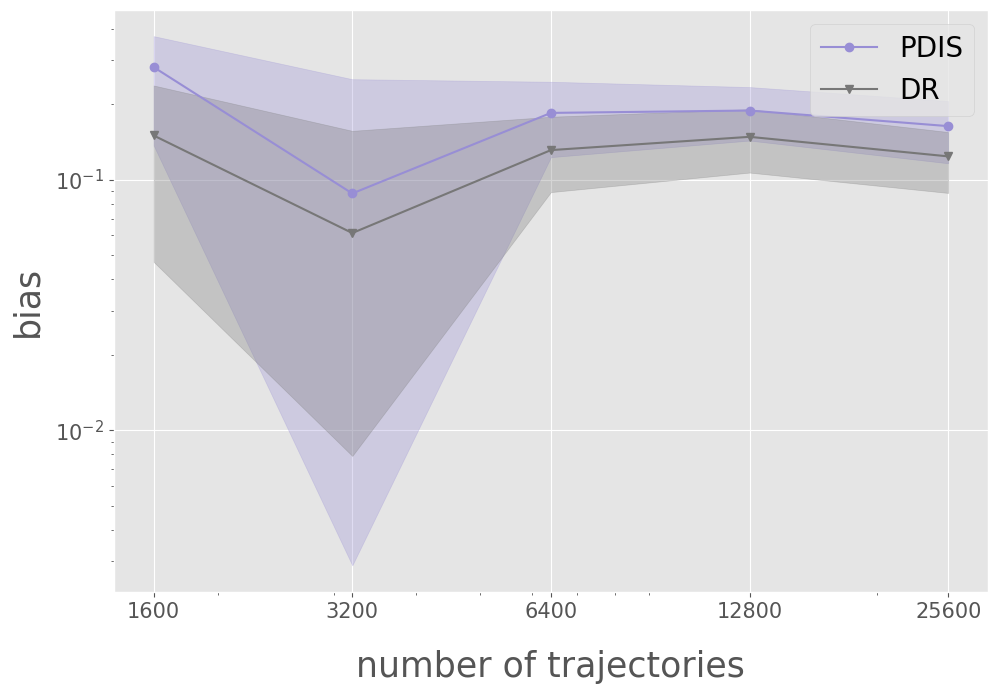

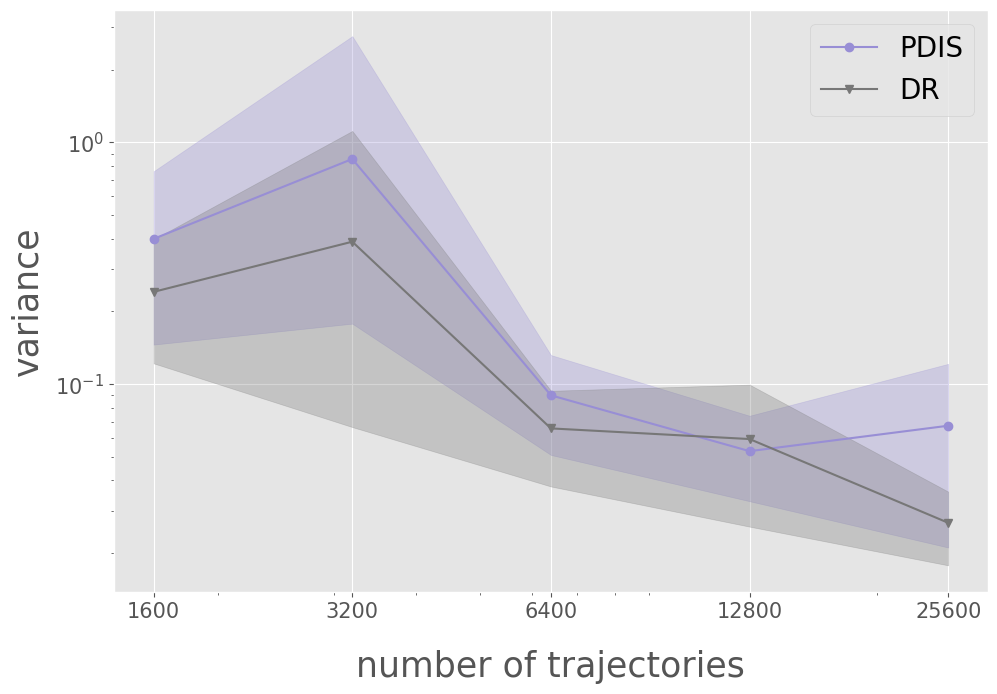

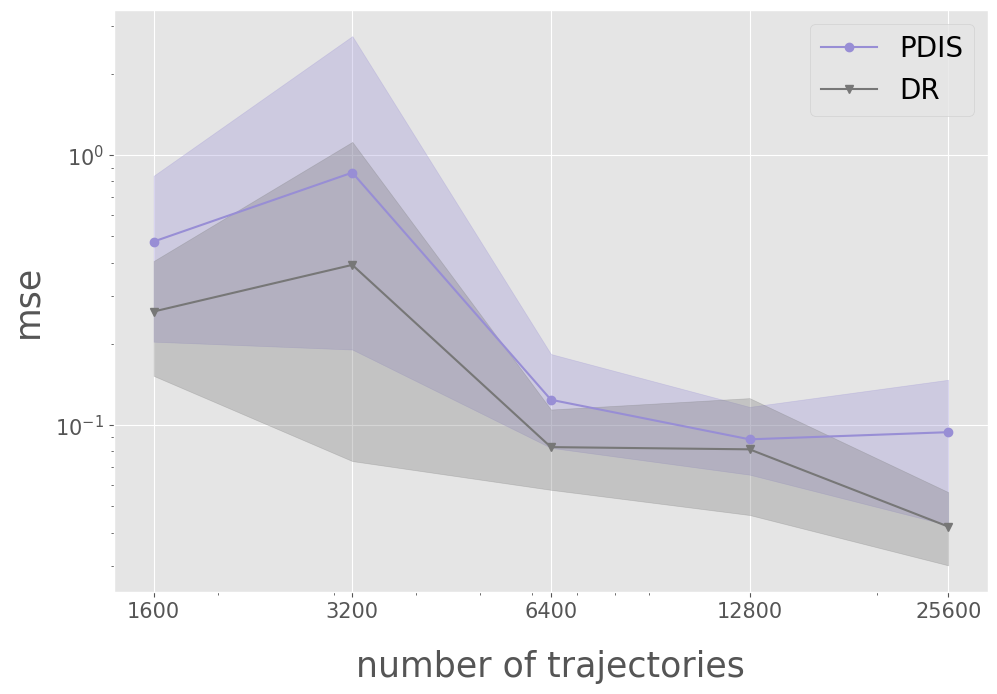

In [83]:
visualize(
    bias_result_df,
    variance_result_df,
    mse_result_df,
    ESTIMATORS=ESTIMATORS,
    estimators=estimators,
    x_scales=x_scales,
    x_label=x_label,
    log_dir=f"../tutorial/{tmp_log_dir}",
    yscale_log=True,
    xscale_log=True,
)